This program generates spectrograms.

In [806]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
import math
import random
import time
from scipy import stats
import sklearn
from sklearn.metrics import accuracy_score

In [622]:
pi=math.pi
tan=math.tan
cos=math.cos
sin=math.sin
exp=math.exp
sqrt=math.sqrt

In [623]:
image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
freq_min=10
freq_max=image.shape[1]
t_min=10
t_max=image.shape[0]
mean_life=15

Angle of track: 51.894676343675286
Time:get_image() 0.06083536148071289
Time:get_gray() 0.0010597705841064453
Time:get_binary_gray 0.23636889457702637
Threshold for True Binary Spectrogram: 0.010484843
Time:get_pixel_gray() 0.000997781753540039
Time:get_noisy_binary_img() 0.003988981246948242
Threshold for Noisy Binary Spectrogram: 3.3588425069099834
Time:get_hough_space() 1592738704.8711946


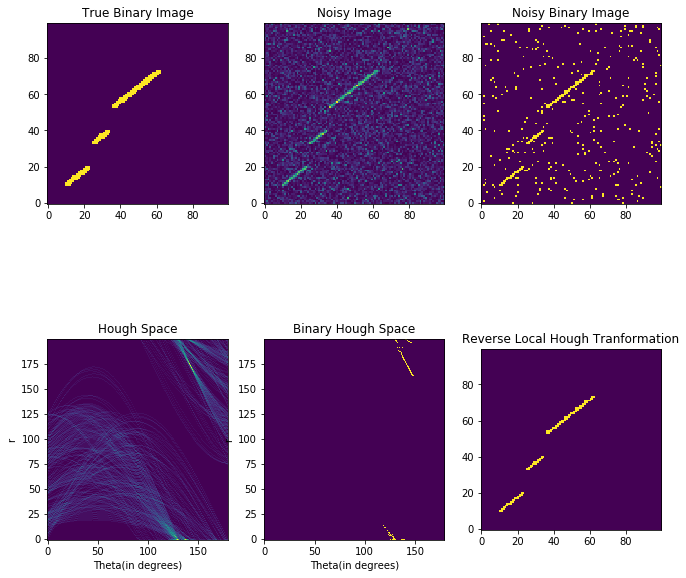

accuracy: 0.6
Angle of track: 48.76384195170679
Time:get_image() 0.06778883934020996
Time:get_gray() 0.002028942108154297
Time:get_binary_gray 0.23734617233276367
Threshold for True Binary Spectrogram: 0.010883968
Time:get_pixel_gray() 0.0009813308715820312
Time:get_noisy_binary_img() 0.006978273391723633
Threshold for Noisy Binary Spectrogram: 3.3705973948890735
Time:get_hough_space() 1592738709.8075602


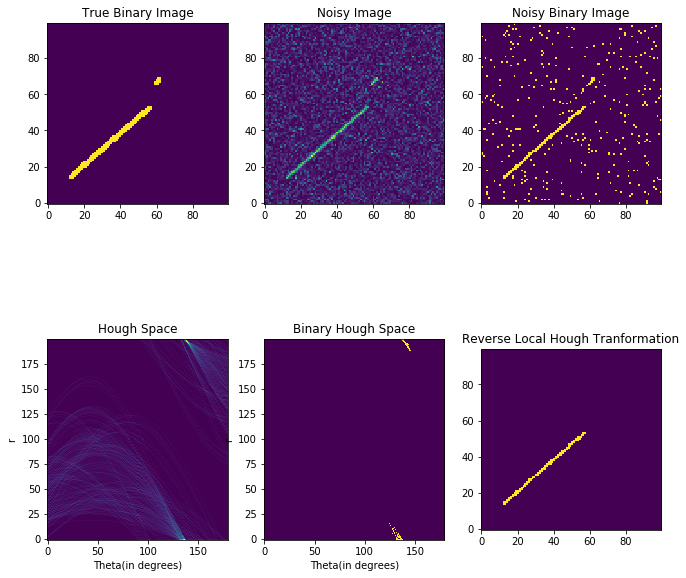

accuracy: 0.56
Angle of track: 53.37057071540089
Time:get_image() 0.10467052459716797
Time:get_gray() 0.0
Time:get_binary_gray 0.2862403392791748
Threshold for True Binary Spectrogram: 0.011290623
Time:get_pixel_gray() 0.0019588470458984375
Time:get_noisy_binary_img() 0.005983114242553711
Threshold for Noisy Binary Spectrogram: 3.418319519913293
Time:get_hough_space() 1592738716.8245153


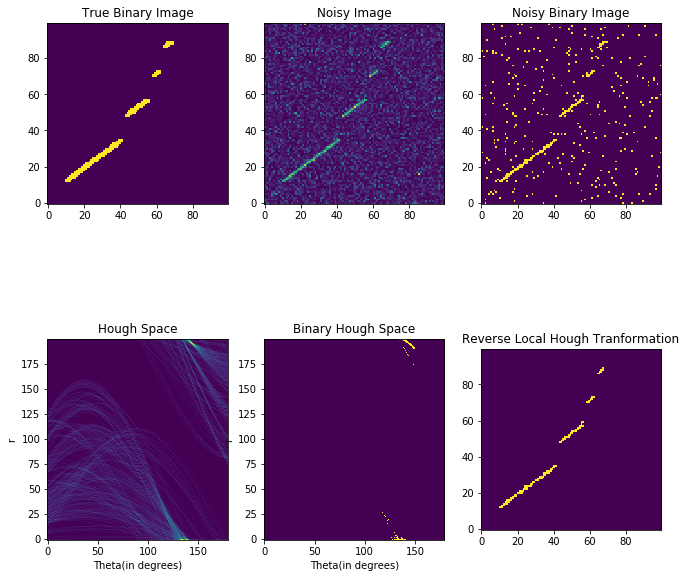

accuracy: 0.56


In [971]:
fig=3
for N in range(fig):
    start=time.time()
    
    alpha=random.uniform(0.785398,0.959931) #The angle made by the generated line(between 20 and 70 degrees)
    print("Angle of track:",((180/pi)*alpha))
    SNR=2
    sigma=0.5
    
    w0=random.randint(freq_min,15)
    t0=random.randint(t_min,15)
        
    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
    pixel=get_image(image,w0,t0,alpha)#to get the track without any noise
    
    pixel_gray=get_gray(pixel)#to get the grayscale of the track image
    
    th_true=np.mean(pixel)
    
    binary_gray=get_binary_gray(pixel_gray,th_true)#to get the true track pixels
   
    print("Threshold for True Binary Spectrogram:",th_true)
    
    pixel_new=get_pixel_new(pixel_gray)#to introduce gaussian noise into the image
    
    th_noisy=np.mean(pixel_new)+2*np.std(pixel_new)
    
    pixel_new_binary=get_noisy_binary_img(pixel_new,th_noisy)
    
    print("Threshold for Noisy Binary Spectrogram:",th_noisy)
    
    hough_space,points_x,points_y=get_hough_space(pixel_new,pixel_new_binary)#hough space generator
    
    max_points=int(math.hypot(pixel.shape[0],pixel.shape[1]))
    
    hough_space_binary,index_continuous,points_x,points_y=get_hough_space_binary(hough_space,points_x,points_y)
    
    reverse_hough=get_reverse_hough(pixel,hough_space,hough_space_binary,points_x,points_y,index_continuous)
    
    plt.figure(figsize=(11,11))
    plt.subplot(231), plt.imshow(binary_gray,origin='lower'),plt.title('True Binary Image')
    plt.subplot(232), plt.imshow(pixel_new,origin='lower'),plt.title('Noisy Image')
    plt.subplot(233), plt.imshow(pixel_new_binary,origin='lower'),plt.title('Noisy Binary Image')
    plt.subplot(234), plt.imshow(hough_space,origin='lower'),plt.title('Hough Space'),plt.xlabel('Theta(in degrees)'),plt.ylabel('r')
    plt.subplot(235), plt.imshow(hough_space_binary,origin='lower'),plt.title('Binary Hough Space'),plt.xlabel('Theta(in degrees)'),plt.ylabel('r')
    plt.subplot(236), plt.imshow(reverse_hough,origin='lower'),plt.title('Reverse Local Hough Tranformation')
    plt.show()
    
    #if N==0:
        #TPR_avg=np.zeros(shape=(max_points))
        #FPR_avg=np.zeros(shape=(max_points))
    
    accuracy=get_accuracy(binary_gray,reverse_hough)
    print("accuracy:",accuracy)
    
    #TPR,FPR=get_positive_rates(binary_gray,reverse_hough,hough_space,points_x,points_y)
    #for k in range(max_points):
        #TPR_avg[k]=TPR_avg[k]+TPR[k]
        #FPR_avg[k]=FPR_avg[k]+FPR[k]
    
   # print_ROC(TPR,FPR)
    
#for k in range(max_points):
   # TPR_avg[k]=TPR_avg[k]/fig
   # FPR_avg[k]=FPR_avg[k]/fig
       
#print_ROC_avg(TPR_avg,FPR_avg)
#end=time.time()
#print("-----------------------") 
#print(end-start)
#print("-----------------------")

Each time bin corresponds to an actual time difference of 0.0002 seconds. 

Each frequency bin corresponds to an actual frequency of 3 MHz.

In [442]:
def get_image(image,w0,t0,angle):
    start=time.time()
    t_prev=t0
    freq_prev=w0
    
    while(True):
        scatter_time=math.floor(t_prev+np.random.exponential(mean_life))  #Scattering times follow an exponential distribution
       # scatter_time=random.randint(t_prev+mean_life,t_prev+3*mean_life) 
        scatter_freq=round(((scatter_time-t_prev)/tan(angle))+freq_prev)
        if((scatter_time>=t_max)or(scatter_freq>=freq_max)):
            break
            
        ybar=freq_prev
        xbar=t_prev
    
        for i in range(t_prev,scatter_time):
            for j in range(freq_prev,scatter_freq):
                intensity=SNR*exp(-((((j-ybar))*sin(alpha))-(((i-xbar))*cos(alpha)))**2/(2*(sigma)**2))
                image[j,i]=(intensity,intensity,0)
                
        t_prev=scatter_time+1
        freq_prev=int(scatter_freq+get_energy_loss())
        
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i,j][0]==image[i,j][1]==image[i,j][2]==1):
                image[i,j]=(0,0,0)
    end=time.time()
    print("Time:get_image()",end-start)
    return image

In [443]:
def get_energy_loss():
    u=np.random.uniform(0,1)
    if(u<=0.48):
        gen_loss=np.random.normal(12.6,0.925)
    else:
        while(True):
            gen_loss=stats.cauchy.rvs(14.1,6.25)
            if(gen_loss>=14.1):break
    return(gen_loss)

In [444]:
def get_gray(pixel):
    start=time.time()
    pixel_gray=np.dot(pixel,[1,1,1])
    end=time.time()
    print("Time:get_gray()",end-start)
    return pixel_gray

In [445]:
def get_binary_gray(pixel_gray,th_true):
    start=time.time()
    binary_gray=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(pixel_gray.shape[0]):
        for j in range(pixel_gray.shape[1]):
            binary_gray[i,j]=0 if (pixel_gray[i,j]<(th_true*np.max(pixel_gray))) else 1
    end=time.time()
    print("Time:get_binary_gray",end-start)
    return binary_gray

In [446]:
def get_pixel_new(pixel_gray):
    start=time.time()
    noise=np.random.exponential(1.0,pixel_gray.shape)    
    pixel_new = SNR*pixel_gray+noise
    end=time.time()
    print("Time:get_pixel_gray()",end-start)
    return pixel_new

In [447]:
def get_noisy_binary_img(pixel_new,th_noisy):
    start=time.time()
    noisy_binary_img=np.zeros(shape=(pixel_new.shape[0],pixel_new.shape[1]))
    for i in range(0,pixel_new.shape[0]):
        for j in range(0,pixel_new.shape[1]):
            noisy_binary_img[i,j]=0 if (pixel_new[i,j]<th_noisy) else 1
            
    end=time.time()
    print("Time:get_noisy_binary_img()",end-start)
    return noisy_binary_img

In [950]:
def get_hough_space(pixel_new,pixel_new_binary):

    x_max = pixel_new.shape[0]
    y_max = pixel_new.shape[1]
    size=10
    centre_x=int(size/2)
    centre_y=int(size/2)

    theta_max = 1.0 *pi
    theta_min = 0.0

    r_min = 0.0
    r_max = math.hypot(pixel_new.shape[0],pixel_new.shape[1])

    r_dim = 200
    theta_dim = 180

    count_coord=300
    points_x=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
    points_y=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
    hough_space = np.zeros(shape=(r_dim,theta_dim),dtype='int')
    
    sum_pixel=0
    th_local=np.mean(pixel_new_binary)
    for x in range(centre_x,x_max-int(size/2),size):   #The two outer loops control the scanning box
        for y in range(centre_y,y_max-int(size/2),size):
            sum_pixel=0
            for i in range(x-int(size/2),x+int(size/2)):  #These loops scan through the box and find the sum of pixel intensities within the box
                for j in range(y-int(size/2),y+int(size/2)):
                    sum_pixel=sum_pixel+pixel_new_binary[i,j]
                    
            if(sum_pixel/(size)**2)>=th_local:      
                for i in range(x-int(size/2),x+int(size/2)):
                    for j in range(y-int(size/2),y+int(size/2)): 
                        if(pixel_new_binary[i,j]==1):
                            for itheta in range(theta_dim):
                                theta =(1.0*itheta*theta_max)/theta_dim
                                r = i*cos(theta)+j*sin(theta)
                                ir = int((r-r_min)/(r_max-r_min) * r_dim)
                                #print(ir)
                                points_x[ir,itheta,hough_space[ir,itheta]]=i
                                points_y[ir,itheta,hough_space[ir,itheta]]=j        
                                hough_space[ir,itheta] = hough_space[ir,itheta] + 1
                          
    return hough_space,points_x,points_y

In [969]:
def get_hough_space_binary(hough_space,points_x,points_y):
    start=time.time()
    r_dim = 200 
    theta_dim = 180
    
    hough_space_binary= np.zeros(shape=(r_dim,theta_dim),dtype='int')
    index_continuous= np.zeros(shape=(r_dim,theta_dim,2),dtype='int')
    for i in range(hough_space.shape[0]):
        for j in range(hough_space.shape[1]):
            label_min_x=0
            label_max_x=0
            label_min_y=0
            label_max_y=0
            if(hough_space[i,j]>=12):
                points_x[i,j].sort()
                start=0
                while(points_x[i,j,start]==0):
                    start=start+1
                    
                label_min_x=start
                label_max_x=start+1 
                index_lower_x=label_min_x
                index_upper_x=label_max_x
                while(index_upper_x<300):
                    if((points_x[i,j])[index_upper_x]-(points_x[i,j])[index_upper_x-1]==0 or (points_x[i,j])[index_upper_x]-(points_x[i,j])[index_upper_x-1]==1):
                        if((index_upper_x==299)and(index_upper_x-index_lower_x-1>label_max_x-label_min_x)):
                            label_max_x=index_upper_x
                            label_min_x=index_lower_x
                            break
                        index_upper_x=index_upper_x+1
                        continue
                    
                    if(index_upper_x-(index_lower_x+1)>label_max_x-label_min_x):
                        label_min_x=index_lower_x
                        label_max_x=index_upper_x-1
                    index_lower_x=index_lower_x+1
                    index_upper_x=index_lower_x+1
                    
                    
                points_y[i,j].sort()
                start=0
                while(points_y[i,j,start]==0):
                    start=start+1
                    
                label_min_y=start
                label_max_y=start+1 
                index_lower_y=label_min_y
                index_upper_y=label_max_y
                while(index_upper_y<300):
                    if((points_y[i,j])[index_upper_y]-(points_y[i,j])[index_upper_y-1]==0 or (points_y[i,j])[index_upper_y]-(points_y[i,j])[index_upper_y-1]==1 or (points_y[i,j])[index_upper_y]-(points_y[i,j])[index_upper_y-1]==1):
                        index_upper_y=index_upper_y+1
                        if((index_upper_y==299)and(index_upper_y-index_lower_y-1>label_max_y-label_min_y)):
                            label_max_y=index_upper_y
                            label_min_y=index_lower_y
                            break
                        continue
                    
                    if(index_upper_y-(index_lower_y+1)>label_max_y-label_min_y):
                        label_min_y=index_lower_y
                        label_max_y=index_upper_y-1
                    index_lower_y=index_lower_y+1
                    index_upper_y=index_lower_y+1
                    
                
            if(label_max_x-label_min_x>=3 and label_max_y-label_min_y>=2 and label_max_y-label_min_y<=label_max_x-label_min_x+2):                   
                hough_space_binary[i,j]=1
                index_continuous[i,j,0]=label_min_x
                index_continuous[i,j,1]=label_max_x+1
            else:
                hough_space_binary[i,j]=0
    end=time.time()
    print("Time:get_hough_space()",end-start)
    return hough_space_binary,index_continuous,points_x,points_y

In [895]:
def get_reverse_hough(pixel,hough_space,hough_space_binary,points_x,points_y,index_continuous):
    reverse_hough=np.zeros(shape=(pixel.shape[0],pixel.shape[1]))
    for r in range(hough_space.shape[0]):
        for theta in range(hough_space.shape[1]):
            if(hough_space_binary[r,theta]==1):
                for l in range(index_continuous[r,theta,0],index_continuous[r,theta,1]):
                    reverse_hough[points_x[r,theta,l],points_y[r,theta,l]]=1
    return(reverse_hough)

In [796]:
def get_positive_rates(binary_gray,reverse_hough,hough_space,points_x,points_y):
    start=time.time()
    TPR=np.zeros(shape=(max_points))
    FPR=np.zeros(shape=(max_points))
    
    y_true=np.zeros(shape=(binary_gray.shape[0],binary_gray.shape[1]))
    for k in range(binary_gray.shape[0]):
        for l in range(binary_gray.shape[1]):
            y_true[k,l]=binary_gray[k,l]
    y_true=y_true.flatten()
    
    r_dim = 200 
    theta_dim = 180
    
    for thresh in range(0,np.max(hough_space)):   
        TP=FP=TN=FN=0  
        y_pred=np.zeros(shape=(binary_gray.shape[0],binary_gray.shape[1]))
        
        if thresh==0:
            y_pred=1
            
        else:
            for i in range(hough_space.shape[0]):
                for j in range(hough_space.shape[1]):
                    if (hough_space[i,j]>=thresh):            
                        for l in range(hough_space[i,j]):
                            y_pred[points_x[i,j,l],points_y[i,j,l]]=1
                    
        y_pred=y_pred.flatten()
  
        for k in range(binary_gray.shape[0]*binary_gray.shape[1]):
            if(y_true[k]==1 and y_pred[k]==1):
                TP=TP+1
                    
            elif(y_true[k]==1 and y_pred[k]==0):
                FN=FN+1
                        
            elif(y_true[k]==0 and y_pred[k]==0):
                TN=TN+1
               
            elif(y_true[k]==0 and y_pred[k]==1):
                FP=FP+1 
        
        TPR[thresh]=TP/(TP+FN)
        FPR[thresh]=FP/(FP+TN)
    
    end=time.time()
    print("Time:get_positive_rates()",end-start)
    return TPR,FPR

In [808]:
def get_accuracy(binary_true,reverse_hough):
    y_true=binary_true
    y_pred=reverse_hough
    accuracy=accuracy_score(y_true,y_pred,normalize=True,sample_weight=None)
    return accuracy

In [452]:
def print_ROC(TPR,FPR):
    start=time.time()
    plt.plot(FPR,TPR)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    end=time.time()
    print("Time:print_ROC()",end-start)
    plt.show()

In [453]:
def print_ROC_avg(TPR_avg,FPR_avg):
    start=time.time()
    plt.plot(FPR_avg,TPR_avg)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC')
    end=time.time()
    print("Time:print_ROC_avg",end-start)
    plt.show()